In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import unicodedata
from tabulate import tabulate

In [2]:
feminicidios = pd.read_csv('../data/Observatorio_Feminicidios_Colombia.csv', encoding='utf-8', sep=';')

colombia = gpd.read_file("../data/MGN2021_MPIO_POLITICO/MGN_MPIO_POLITICO.shp")

<h1>Limpieza de los datos</h1>

<h2>Modificar datasets</h2>

<h3>Función para remover acentos y cambiar las letras a mayusculas</h3> 

In [3]:
def remove_accents_and_uppercase(text):
    if not isinstance(text, str):
        return text
    
    text = ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')
    return text.upper()

<h3>Preprocesamiento del dataset de colombia</h3>

In [4]:
columnas_a_transformar_colombia = ["DPTO_CNMBR", "MPIO_CNMBR"]
colombia[columnas_a_transformar_colombia]=colombia[columnas_a_transformar_colombia].applymap(remove_accents_and_uppercase)

In [5]:
# Seleccionar las columnas de departamento y municipio
depto_municipio = colombia[['DPTO_CNMBR', 'MPIO_CNMBR']]

# Quitar duplicados
depto_municipio = depto_municipio.drop_duplicates()

#Guardar en la carpeta data
depto_municipio.to_csv('../data/departamento-municipio.csv', index=False)

<h2>Preprocesamiento del dataset de feminicidios</h2>

In [6]:
columnas_a_transformar_feminicidios=["tipo_violencia", "departamento", "municipio"]
feminicidios[columnas_a_transformar_feminicidios]=feminicidios[columnas_a_transformar_feminicidios].applymap(remove_accents_and_uppercase)

<h3>Cambios de columnas y valores</h3>

<h5>Configuración de columnas tipo int y date</h5>

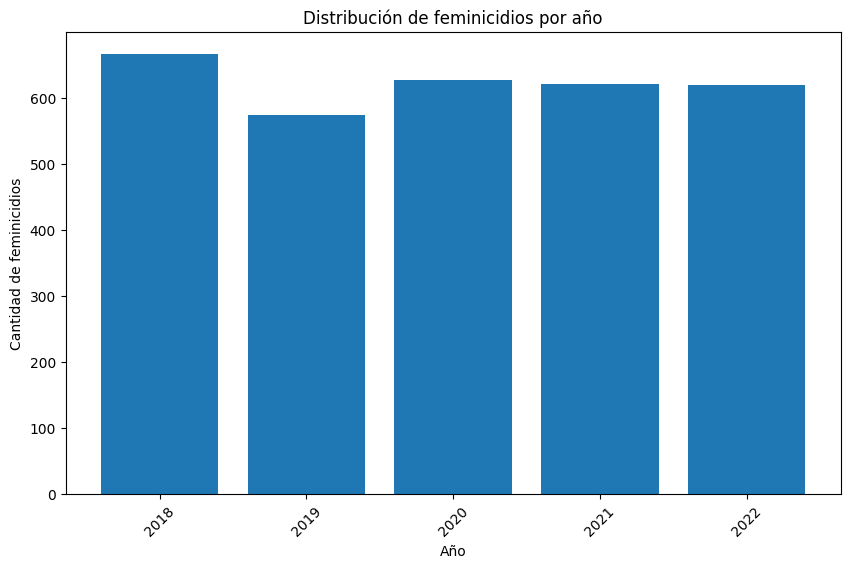

In [7]:
feminicidios=feminicidios.rename(columns={'nro':'numero'})

feminicidios['ano'] = feminicidios['ano'].astype(int)

feminicidios['fecha_en_prensa']=pd.to_datetime(feminicidios['fecha_en_prensa'], errors='coerce', dayfirst=True)

feminicidios=feminicidios.dropna(subset=['fecha_en_prensa'])

ano_counts = feminicidios['ano'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(ano_counts.index, ano_counts.values)
plt.xlabel('Año')
plt.ylabel('Cantidad de feminicidios')
plt.title('Distribución de feminicidios por año')
plt.xticks(ano_counts.index, rotation=45)
plt.show()

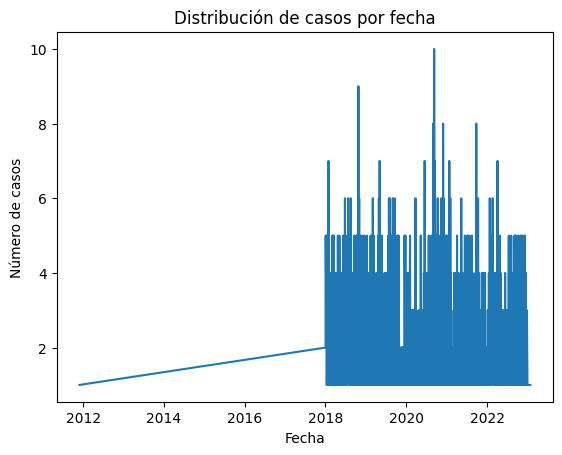

In [10]:
datos_por_fecha = feminicidios.groupby('fecha_en_prensa')['numero'].count()

plt.plot(datos_por_fecha.index, datos_por_fecha.values)

plt.xlabel('Fecha')
plt.ylabel('Número de casos')
plt.title('Distribución de casos por fecha')

plt.show()

In [11]:
feminicidios = feminicidios[feminicidios['fecha_en_prensa'].between('2018-01-01', '2023-12-31')]

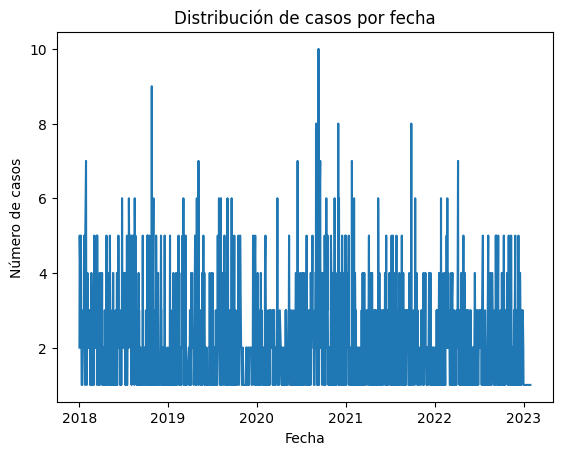

In [12]:
datos_por_fecha = feminicidios.groupby('fecha_en_prensa')['numero'].count()

plt.plot(datos_por_fecha.index, datos_por_fecha.values)

plt.xlabel('Fecha')
plt.ylabel('Número de casos')
plt.title('Distribución de casos por fecha')

plt.show()

<h5>Estado actual del dataset</h5>

In [13]:
print(feminicidios.shape)

(3106, 6)


In [14]:
print(feminicidios.describe())

            numero          ano
count  3106.000000  3106.000000
mean   1555.079524  2019.984224
std     898.406635     1.427838
min       1.000000  2018.000000
25%     777.250000  2019.000000
50%    1553.500000  2020.000000
75%    2332.750000  2021.000000
max    3111.000000  2022.000000


In [15]:
print(feminicidios.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3106 entries, 0 to 3110
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   numero           3106 non-null   int64         
 1   ano              3106 non-null   int32         
 2   fecha_en_prensa  3106 non-null   datetime64[ns]
 3   tipo_violencia   3106 non-null   object        
 4   departamento     3106 non-null   object        
 5   municipio        3021 non-null   object        
dtypes: datetime64[ns](1), int32(1), int64(1), object(3)
memory usage: 157.7+ KB
None


In [16]:
print(feminicidios.head())

   numero   ano fecha_en_prensa tipo_violencia departamento municipio
0       1  2018      2018-01-02    FEMINICIDIO    ANTIOQUIA  HISPANIA
1       2  2018      2018-01-02    FEMINICIDIO         META          
2       3  2018      2018-01-03    FEMINICIDIO    ANTIOQUIA  MEDELLIN
3       4  2018      2018-01-03    FEMINICIDIO    ANTIOQUIA  MEDELLIN
4       5  2018      2018-01-03    FEMINICIDIO    ANTIOQUIA  MEDELLIN


<h5>Configuración de columnas espaciales</h5>

Las columnas espaciales son Departamento y Municipio

Se reemplazan los valores en la columna municipio que solo son espacios por nan

In [17]:
feminicidios['municipio']=feminicidios['municipio'].str.strip().replace('', np.nan)

feminicidios_sin_municipio=feminicidios[feminicidios['municipio'].isna()]

cantidad_feminicidios_por_ano_y_tipo=feminicidios.groupby(['ano', 'tipo_violencia']).size().reset_index(name='total registros')

cantidad_feminicidios_sin_municipio_por_ano_y_tipo=feminicidios_sin_municipio.groupby(['ano', 'tipo_violencia']).size().reset_index(name='registros sin municipio')

cantidad_feminicidios_con_y_sin_municipios=cantidad_feminicidios_por_ano_y_tipo.merge(cantidad_feminicidios_sin_municipio_por_ano_y_tipo, on=['ano', 'tipo_violencia'], how='left')

cantidad_feminicidios_con_y_sin_municipios['registros sin municipio']=cantidad_feminicidios_con_y_sin_municipios['registros sin municipio'].fillna(0).astype(int)

print(tabulate(cantidad_feminicidios_con_y_sin_municipios, headers='keys', tablefmt='pretty'))

+---+------+------------------+-----------------+-------------------------+
|   | ano  |  tipo_violencia  | total registros | registros sin municipio |
+---+------+------------------+-----------------+-------------------------+
| 0 | 2018 |   FEMINICIDIO    |       658       |           512           |
| 1 | 2018 | TRANSFEMINICIDIO |        8        |            5            |
| 2 | 2019 |   FEMINICIDIO    |       562       |           420           |
| 3 | 2019 | TRANSFEMINICIDIO |       12        |            8            |
| 4 | 2020 |   FEMINICIDIO    |       613       |           290           |
| 5 | 2020 | TRANSFEMINICIDIO |       14        |            8            |
| 6 | 2021 |   FEMINICIDIO    |       604       |            3            |
| 7 | 2021 | TRANSFEMINICIDIO |       17        |            0            |
| 8 | 2022 |   FEMINICIDIO    |       597       |            0            |
| 9 | 2022 | TRANSFEMINICIDIO |       21        |            0            |
+---+------+

C:\Users\sercabni\AppData\Local\Temp\ipykernel_13728\1530129833.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feminicidios['municipio']=feminicidios['municipio'].str.strip().replace('', np.nan)


In [18]:
municipio_principal_por_departamento = feminicidios.groupby('departamento')['municipio'].agg(lambda x: x.value_counts().idxmax() if not x.empty and not x.value_counts().empty else None)

municipio_principal_por_departamento_df=municipio_principal_por_departamento.reset_index()

print(tabulate(municipio_principal_por_departamento_df, headers='keys', tablefmt='pretty'))

+----+--------------------+------------------------+
|    |    departamento    |       municipio        |
+----+--------------------+------------------------+
| 0  |     ANTIOQUIA      |        MEDELLIN        |
| 1  |       ARAUCA       |        SARAVENA        |
| 2  |     ATLANTICO      |      BARRANQUILLA      |
| 3  |    BOGOTA D.C.     |      BOGOTA D.C.       |
| 4  |      BOLIVAR       |       CARTAGENA        |
| 5  |       BOYACA       |         TUNJA          |
| 6  |       CALDAS       |       MANIZALES        |
| 7  |      CAQUETA       |  SAN JOSE DEL FRAGUA   |
| 8  |      CASANARE      |         YOPAL          |
| 9  |       CAUCA        | SANTANDER DE QUILICHAO |
| 10 |       CESAR        |       VALLEDUPAR       |
| 11 |       CHOCO        |         QUIBDO         |
| 12 |      CORDOBA       |        MONTERIA        |
| 13 |    CUNDINAMARCA    |         SOACHA         |
| 14 |      GUAJIRA       |         MAICAO         |
| 15 |      GUAVIARE      |        CALAMAR    

Debido a que Vaupes tiene un valor nulo en el campo de municipio más frecuente, se le asignara el valor de MITU, el cual es el municipio con la mayor población en dicho departamento y la capital del mismo.

In [19]:
if "VAUPES" in municipio_principal_por_departamento.index:
    municipio_principal_por_departamento.loc["VAUPES"] = "MITU"
    
municipio_principal_por_departamento_df=municipio_principal_por_departamento.reset_index()

print(tabulate(municipio_principal_por_departamento_df, headers='keys', tablefmt='pretty'))

+----+--------------------+------------------------+
|    |    departamento    |       municipio        |
+----+--------------------+------------------------+
| 0  |     ANTIOQUIA      |        MEDELLIN        |
| 1  |       ARAUCA       |        SARAVENA        |
| 2  |     ATLANTICO      |      BARRANQUILLA      |
| 3  |    BOGOTA D.C.     |      BOGOTA D.C.       |
| 4  |      BOLIVAR       |       CARTAGENA        |
| 5  |       BOYACA       |         TUNJA          |
| 6  |       CALDAS       |       MANIZALES        |
| 7  |      CAQUETA       |  SAN JOSE DEL FRAGUA   |
| 8  |      CASANARE      |         YOPAL          |
| 9  |       CAUCA        | SANTANDER DE QUILICHAO |
| 10 |       CESAR        |       VALLEDUPAR       |
| 11 |       CHOCO        |         QUIBDO         |
| 12 |      CORDOBA       |        MONTERIA        |
| 13 |    CUNDINAMARCA    |         SOACHA         |
| 14 |      GUAJIRA       |         MAICAO         |
| 15 |      GUAVIARE      |        CALAMAR    

In [20]:
def rellenar_campos_de_municipio_vacio(row):
    if pd.isna(row['municipio']):
        return municipio_principal_por_departamento[row['departamento']]
    else:
        return row['municipio']

Se hace entonces la variante del dataframe de feminicidios en el que los campos vacios en la columna de municipio han sido completados con los valores mas comunes de cada departamento respectivamente.

In [21]:
f_v2=feminicidios.copy()
f_v2['municipio']=f_v2.apply(rellenar_campos_de_municipio_vacio, axis=1)

In [22]:
print(f_v2.shape)

(3106, 6)


In [23]:
missing_values = f_v2.isna().sum()

# Muestra las columnas con valores faltantes y la cantidad de registros faltantes en cada columna
print("Campos vacíos o valores inválidos en el DataFrame de feminicidios:")
print(missing_values[missing_values > 0])

Campos vacíos o valores inválidos en el DataFrame de feminicidios:
Series([], dtype: int64)


In [24]:
# Encuentra los registros con al menos un campo vacío
rows_with_missing_values = f_v2[f_v2.isna().any(axis=1)]

# Muestra los registros con campos vacíos
print("Registros con campos vacíos en el DataFrame de feminicidios:")
print(rows_with_missing_values)


Registros con campos vacíos en el DataFrame de feminicidios:
Empty DataFrame
Columns: [numero, ano, fecha_en_prensa, tipo_violencia, departamento, municipio]
Index: []


In [25]:
f_v2.head()

,numero,ano,fecha_en_prensa,tipo_violencia,departamento,municipio
0,1,2018,2018-01-02,FEMINICIDIO,ANTIOQUIA,HISPANIA
1,2,2018,2018-01-02,FEMINICIDIO,META,VILLAVICENCIO
2,3,2018,2018-01-03,FEMINICIDIO,ANTIOQUIA,MEDELLIN
3,4,2018,2018-01-03,FEMINICIDIO,ANTIOQUIA,MEDELLIN
4,5,2018,2018-01-03,FEMINICIDIO,ANTIOQUIA,MEDELLIN


In [26]:
columnas_a_eliminar=['numero','ano','tipo_violencia']
f_v2=f_v2.drop(columnas_a_eliminar, axis=1)
f_v2.head()

,fecha_en_prensa,departamento,municipio
0,2018-01-02,ANTIOQUIA,HISPANIA
1,2018-01-02,META,VILLAVICENCIO
2,2018-01-03,ANTIOQUIA,MEDELLIN
3,2018-01-03,ANTIOQUIA,MEDELLIN
4,2018-01-03,ANTIOQUIA,MEDELLIN


In [27]:
f_v2.shape

(3106, 3)

In [28]:
f_v2=f_v2.groupby([pd.Grouper(key='fecha_en_prensa', freq='D'), 'departamento', 'municipio']).size().reset_index(name='num_casos')
f_v2.head()

,fecha_en_prensa,departamento,municipio,num_casos
0,2018-01-02,ANTIOQUIA,HISPANIA,1
1,2018-01-02,META,VILLAVICENCIO,1
2,2018-01-03,ANTIOQUIA,MEDELLIN,3
3,2018-01-03,VALLE DEL CAUCA,CALI,2
4,2018-01-05,CORDOBA,MONTERIA,1


In [ ]:
f_v2.to_csv('../data/datos_observatorio_limpios.csv', index=False)